In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from tqdm import tqdm
from theano.tensor.random.utils import RandomStream
import scipy.linalg as sl
import scipy.stats as ss
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import lightkurve as lk
%matplotlib inline

starry.config.quiet = True
np.random.seed(1)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _cho_solve(L, b):
    return tt.slinalg.solve_upper_triangular(L.T, tt.slinalg.solve_lower_triangular(L, b))

class StarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm

        self._mu = sp.mean_ylm
        self._Lambda = sp.cov_ylm

    @property
    def nt(self):
        return self._nt
    @property
    def nlm(self):
        return self._nlm

    @property
    def sys(self):
        return self._sys
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M

    @property
    def logl_marginal(self):
        return self._logl_marginal
    @property
    def a(self):
        return self._a
    @property
    def AInv_chol(self):
        return self._AInv_chol

    def _compute(self, t, flux, sigma_flux):
        M = self.sys.design_matrix(t)[:,:-1] # We don't use any flux from the secondary, so [:, :-1]
        self._M = M

        nlm = self.nlm
        nt = self.nt

        mu = self.mu
        Lambda = self.Lambda

        # We want to enforce that the prior on the constant term in the map is
        # completely flat, so we set the first row and column of the precision
        # matrix to zero we do this manually here.  First we Cholesky decompose:
        #
        # Lambda[1:,1:] = L L^T
        #
        # Then, because of a quirk of theano (no gradients for `cho_solve!`,
        # WTF), we can compute Lambda[1:,1:]^{-1} via
        #
        # Lambda[1:,1:]^{-1} = tt.slinalg.solve_triangular(L.T, tt.slinalg.solve_triangular(L, tt.eye(nlm-1), lower=True), lower=False)
        #
        # encapsulated in our _cho_solve(...) function above
        L = tt.slinalg.cholesky(Lambda[1:,1:])
        Lambda_inv = _cho_solve(L, tt.eye(nlm-1))
        Lambda_inv = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv)

        sigma_flux2 = tt.square(sigma_flux)
        MTCinv = M.T / sigma_flux2[None, :]
        MTCinvM = tt.dot(MTCinv, M)

        AInv = Lambda_inv + MTCinvM
        AInv_chol = tt.slinalg.cholesky(AInv)
        a = _cho_solve(AInv_chol, tt.dot(Lambda_inv, mu) + tt.dot(MTCinv, flux))

        self._a = a
        self._AInv_chol = AInv_chol

        b = tt.dot(M, mu)
        r = flux - b

        Cinvr = r / sigma_flux2

        rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

        # Identity:
        # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
        # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
        # |B| = | A^-1 | |L[1:,1:]| |C|

        logdetB = tt.sum(tt.log(sigma_flux2)) + 2*tt.sum(tt.log(tt.diag(AInv_chol))) + 2*tt.sum(tt.log(tt.diag(L)))

        # (nt-1) because we have cancelled one dimension due to the flat prior on the [0,0] constant term.
        logl = -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-1)*tt.log(2*np.pi)
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux):
        self._compute(t, flux, sigma_flux)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None):
        if rng is None:
            rng = RandomStream(seed=np.random.randint(1<<32))

        nylm = self.nlm

        self._compute(t, flux, sigma_flux)
        return self.a[None,:] + tt.slinalg.solve_upper_triangular(self.AInv_chol.T, rng.normal(size=(nylm, size))).T

## Helper Distribution functions

In [3]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        initval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)

def ori_xyz(name, testval):
    stellar_ori_x = pm.Normal(name+'_ori_x', mu=0, sigma=1, testval=testval)
    stellar_ori_y = pm.Normal(name+'_ori_y', mu=0, sigma=1, testval=testval)
    stellar_ori_z = pm.Normal(name+'_ori_z', mu=0, sigma=1, testval=testval)

    return stellar_ori_x, stellar_ori_y, stellar_ori_z

def Planet_Inc(name, *args, **kwargs):
    bmax = params[name].get('bmax')
    b = pm.Uniform('b', -bmax, bmax)
    planet_inc = pm.Deterministic(name, 180.0/np.pi*np.arccos(b))
    
    return planet_inc

def Stellar_Ang(name, *args, **kwargs):
    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]
    stellar_ori_x, stellar_ori_y, stellar_ori_z = ori_xyz(name, trueval)

    if "inc" in name:
        return pm.Deterministic(name, 180.0/np.pi*tt.arccos(stellar_ori_z / tt.sqrt(tt.square(stellar_ori_x) + tt.square(stellar_ori_y) + tt.square(stellar_ori_z))))
    
    elif "obl" in name:
        return pm.Deterministic(name, 180.0/np.pi*tt.arctan2(stellar_ori_y, stellar_ori_x))

def Period(name, *args, **kwargs):
    frac_bounds = params[name].get('frac_bounds')

    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]

    def logp(trueval, frac_bounds):
        return pm.Uniform(name+'logp',tt.log(trueval) + np.log1p(-frac_bounds), tt.log(trueval) + np.log1p(frac_bounds))

    period = pm.Deterministic(name, tt.exp(logp(trueval, frac_bounds)))

    return period

def Logarithmic(name, *args, **kwargs):
    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]
    log_rp = pm.Uniform(name+'log', tt.log(trueval/2), tt.log(2*trueval))
    rp = pm.Deterministic(name, tt.exp(log_rp))

    return rp

# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [4]:
def gp_model(t, flux, err, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
            
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        prot = parameter('star.prot')
        stellar_inc = parameter('star.inc')
        stellar_obl = parameter('star.obl')

        porb = parameter('planet.porb')
        t0 = parameter('planet.t0')
        rp = parameter('planet.r')
        planet_inc = parameter('planet.inc')
        mp = parameter('planet.m')
        ecc = parameter('planet.ecc')
        Omega = parameter('planet.Omega')

        pri_model = starry.Primary(starry.Map(ydeg=15, udeg=2, inc=stellar_inc, obl=stellar_obl), 
            r=parameter('star.r'), 
            m=parameter('star.m'), 
            prot=prot, 
            t0=0.0)
        pri_model.map[1] = parameter('star.u1')
        pri_model.map[2] = parameter('star.u2')

        sec_model = starry.Secondary(starry.Map(0,0), 
            t0=t0, 
            r=rp, 
            m=mp, 
            prot=1,
            porb=porb, 
            ecc=ecc, 
            Omega=Omega, 
            inc=planet_inc)
    
        sys_model = starry.System(pri_model, sec_model)

        # Instantiate the GP
        sp_model = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            r=parameter("gp.r"),
            dr=parameter("gp.dr"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            ydeg=15,
            udeg=2,
            marginalize_over_inclination=False,  
        )

        ssp_model = StarryStarryProcess(sys_model, sp_model, len(t), 256)

        pm.Potential('marginal_likelihood', ssp_model.marginal_likelihood(t, flux, err))
        
        return model

In [5]:
def bin_out_of_transit(t, flux, err, params, dt=0.06, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

## Get a light curve

In [6]:
search_result = lk.search_lightcurve('KIC 3861595', author="Kepler", cadence='short')
# Download all available Kepler light curves
lc_collection = search_result.download_all()

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

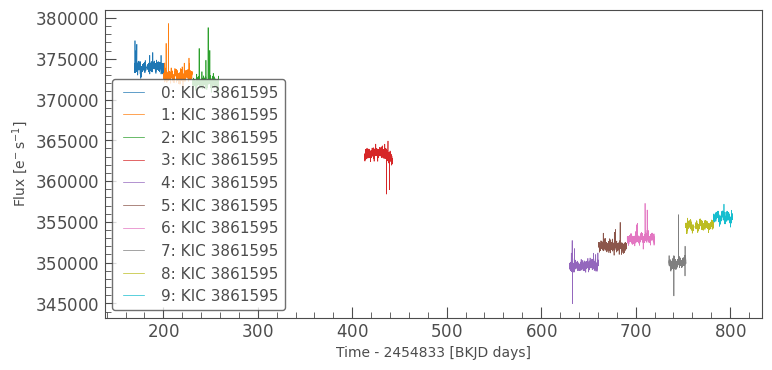

In [7]:
lc_collection.plot()

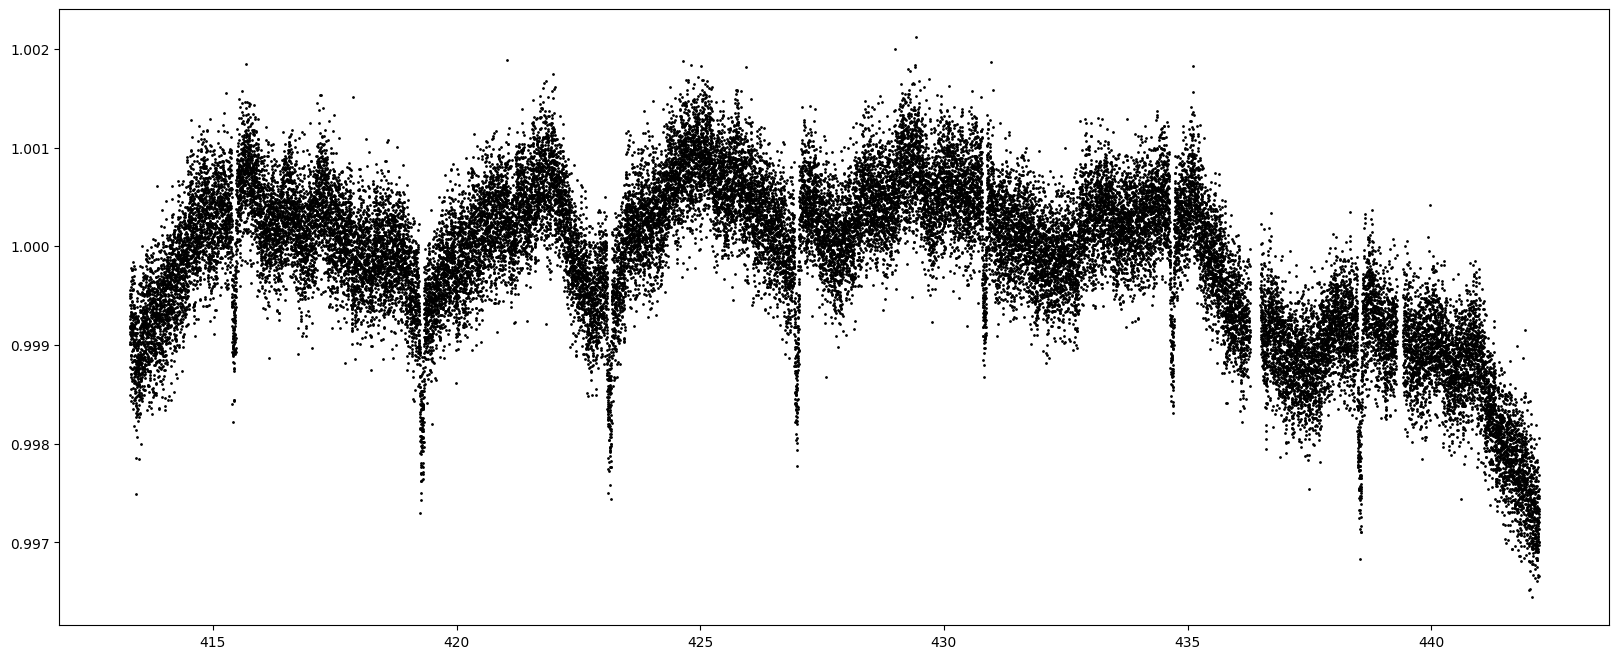

In [8]:
search_result = lk.search_lightcurve('KIC 3861595', author="Kepler", cadence='short', quarter=4)
# Download all available Kepler light curves
lc_collection_q4 = search_result.download_all()

search_result = lk.search_lightcurve('KIC 3861595', author="Kepler", cadence='short')
# Download all available Kepler light curves
lc_collection = search_result.download_all()

all_lc = lc_collection.stitch()
lc_q4 = lc_collection_q4.stitch()

all_lc=all_lc.remove_nans()
lc_q4 = lc_q4.remove_nans()

all_lc = all_lc[all_lc.quality==0]
lc_q4 = lc_q4[lc_q4.quality == 0]

plt.figure(figsize=(20, 8))
plt.plot(lc_q4.time.value, lc_q4.flux, "k.", ms=2)

(200.0, 230.0)

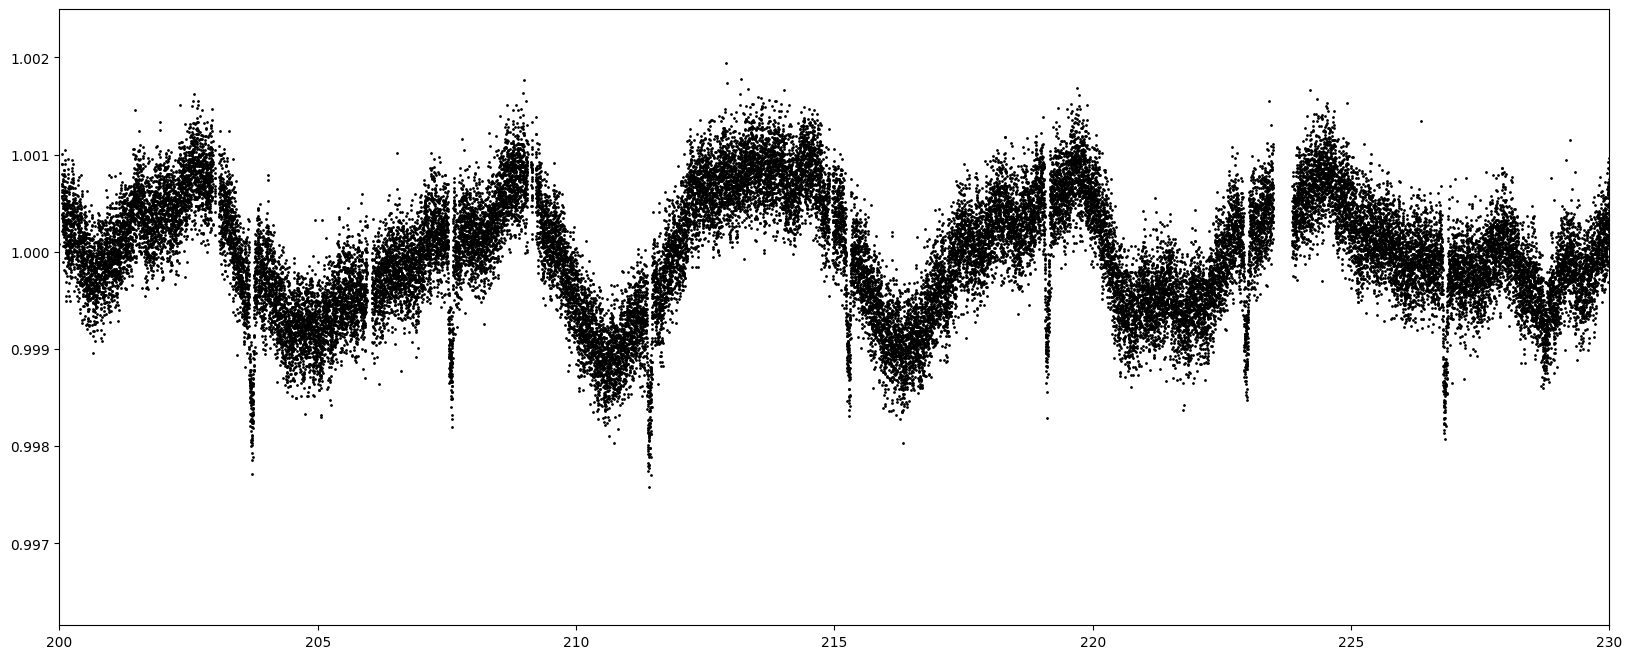

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc.time.value, all_lc.flux, "k.", ms=2)
plt.xlim(200,230)

In [10]:
mask = ((all_lc.time.value <= 230) & (all_lc.time.value >= 206))

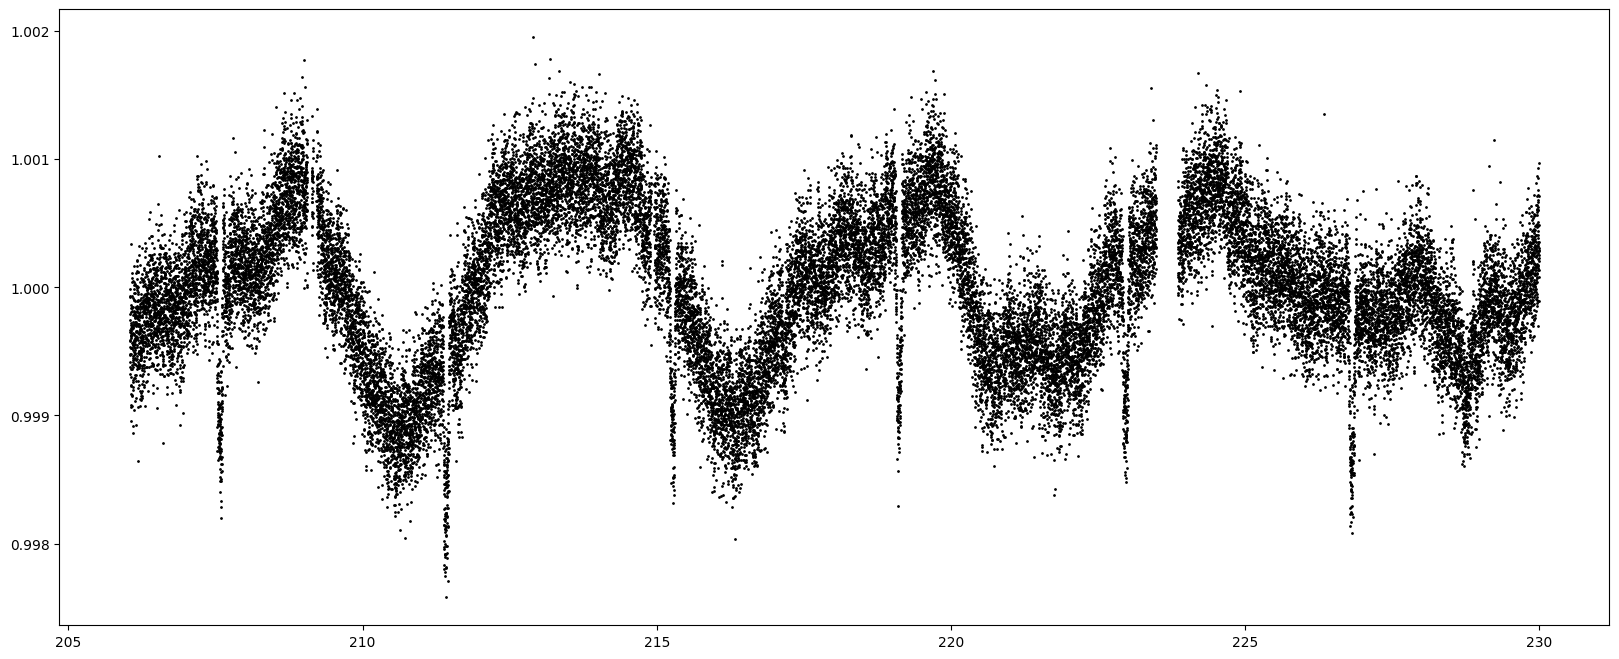

In [11]:
t = all_lc.time.value[mask]
flux = np.array(all_lc.pdcsap_flux.value[mask]) # saving the fluxes with PDCSAP
mean_flux = np.mean(np.array(all_lc.pdcsap_flux.value[mask]))
flux_obs = flux / mean_flux

sigma_flux = np.array(all_lc.pdcsap_flux_err.value[mask]) / mean_flux

data = list(zip(t, flux_obs, sigma_flux))

sorted_data = sorted(data, key=lambda x: x[0])

sorted_times, sorted_fluxes, sorted_errors = zip(*sorted_data)

t = np.array(sorted_times)
flux_obs = np.array(sorted_fluxes)

sigma_flux = np.array(sorted_errors)

plt.figure(figsize=(20, 8))
plt.plot(t, flux_obs, "k.", ms=2)

In [12]:
mSun = 1.989e33 # grams
mJ = 1.898e30 
rJ = 6.99e6 # cm
rSun = 69.634e6

mKepler1658 = 1.45 * mSun
mKepler1658b = 5.88 * mJ # grams
rKepler1658 = 2.89 * rSun 
rKepler1658b = 1.07 * rJ # cm

In [13]:
mKepler1658b / mKepler1658

0.0038696416497633534

In [14]:
params['planet.t0']['truth'] = 122.88
t_, flux_, sigma_flux_ = bin_out_of_transit(t, flux_obs, sigma_flux, params, dt=0.066, binsize=500)
plt.figure(figsize=(18,6))
plt.plot(t, flux_obs, 'k.')
plt.plot(t_, flux_, 'r.')
# plt.errorbar(t_, flux_, yerr=sigma_flux_, fmt='.')
plt.xlim(211,220)

NameError: name 'params' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


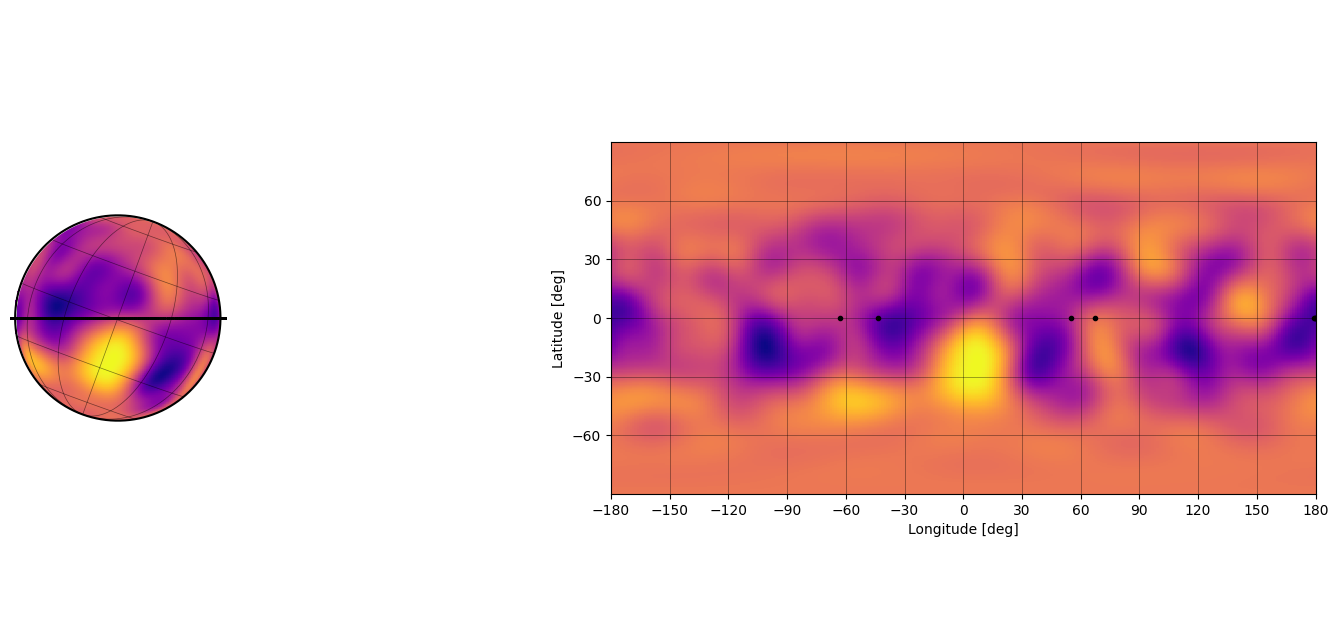

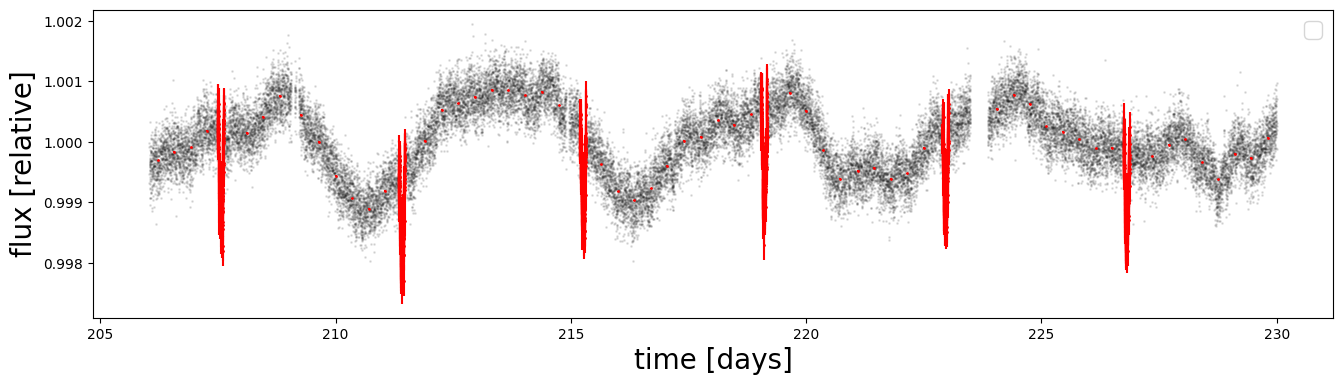

In [15]:
# True parameters & priors
params = {
    "planet.inc": {"truth": 90, "dist": Planet_Inc},
    "planet.ecc": {"truth": 0.06, "dist": Uniform, "args": [0.0, 0.9]},
    "planet.Omega": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 3.84937278, "dist": Uniform, "args": [3.84, 3.85]},
    "planet.t0": {"truth": 122.88, "dist": Uniform, "args": [122.8, 123]},
    "planet.r": {"truth": rKepler1658b / rSun, "dist": Logarithmic},
    "planet.m": {"truth":  mKepler1658b / mSun, "dist": Uniform, "args": [3e-4, 4e-3]},
    "planet.w": {"truth": 352.27, "dist": Angle},

    "star.inc": {"truth": 89, "dist": Stellar_Ang},
    "star.m": {"truth": mKepler1658 / mSun, "dist": Uniform, "args": [0.4, 1]},
    "star.u1": {"truth": 0.0154, "dist": Uniform, "args": [0.0, 0.8]},
    "star.u2": {"truth": 0.0453, "dist": Uniform, "args": [-0.5, 0.1]},
    "star.prot": {"truth": 5.66, "dist": Period},
    "star.obl": {"truth": -20.0, "dist": Stellar_Ang},
    "star.r": {"truth": rKepler1658 / rSun, "dist": Uniform, "args": [0.1, 1]},

    "gp.r": {"truth": 20, "dist": Uniform, "args": [5.0, 35.0]},
    "gp.dr": {"truth": 5.0, "dist": Uniform, "args": [1.0, 10.0]},
    "gp.c": {"truth": 0.3, "dist": Uniform, "args": [0.1, 0.9]},
    "gp.n": {"truth": 15, "dist": Uniform, "args": [0, 60]},
    "gp.mu": {"truth": 15, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 10, "dist": Uniform, "args": [1.0, 30]}
}

t_, flux_, sigma_flux_ = bin_out_of_transit(t, flux_obs, sigma_flux, params, dt=0.066, binsize=500)

# Initializing the time
Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = params['star.prot']['truth'] / 20.0

dt = 0.6
idx = np.zeros(len(t_), dtype=bool)
ntransits = int(np.ceil(t_[-1] / params["planet.porb"]["truth"]))
for n in range(ntransits):
    t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
    idx |= ((t_ > t0 - dt) & (t_ < t0 + dt))
t_in = t_[idx]
t_out = t_[~idx]
flux_in = flux_[idx]
flux_out = flux_[~idx]

nt = len(t)

Ttotal = t[-1] - t[0]

# Setting the priors
# fraction bounds for period priors
prot_frac_bounds = min(params['star.prot']['truth']/Ttotal/2, 0.25)
porb_frac_bounds = min(params['planet.porb']['truth']/Ttotal/2, 0.25)

# Let's add this parameter to the parameter dictionary as a prior
params['star.prot']['frac_bounds'] = prot_frac_bounds
params['planet.porb']['frac_bounds'] = porb_frac_bounds

# semi-major axis
a = (params['star.m']['truth']*np.square(params['planet.porb']['truth']/365.25))**(1/3) * 215.03 # Solar radii
# impact parameter
bmax = params['star.r']['truth'] / a

# Let's add this parameter to the parameter dictionary as a prior
params['planet.inc']['bmax'] = bmax

# Plot the data

map = starry.Map(15, 2)
map.inc = params["star.inc"]["truth"]
map.obl = params["star.obl"]["truth"]
map[1] = params["star.u1"]["truth"]
map[2] = params["star.u2"]["truth"]
star = starry.Primary(map, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]["truth"]) 
planet = starry.Secondary(
    starry.Map(0,0),
    inc=params["planet.inc"]["truth"],
    ecc=params["planet.ecc"]["truth"],
    Omega=params["planet.Omega"]["truth"],
    porb=params["planet.porb"]["truth"],
    t0=params["planet.t0"]["truth"],
    r=params["planet.r"]["truth"],
    m=params["planet.m"]["truth"],
    w=params["planet.w"]["truth"],
)

sys = starry.System(star, planet)
xo, yo, zo = sys.position(t)
xo = xo.eval()[1]
yo = yo.eval()[1]
zo = zo.eval()[1]
theta = (360 * t / params["star.prot"]["truth"]) % 360

# *** Draw 1 sample from the GP
sp = StarryProcess(
    mu=params["gp.mu"]["truth"],
    sigma=params["gp.sigma"]["truth"],
    r=params["gp.r"]["truth"],
    dr=params["gp.dr"]["truth"],
    c=params["gp.c"]["truth"],
    n=params["gp.n"]["truth"],
)

nt = len(t_)
ssp = StarryStarryProcess(sys, sp, len(t_), 256)

y_true = sp.sample_ylm().eval().reshape(-1)
y_true[0] += 1

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
ax[0].set_aspect(1)
ax[0].axis("off")
map[:, :] = y_true
map.show(ax=ax[0])
ax[0].set_ylim(-3, 3)
idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
lat = 180 / np.pi * np.arcsin(yo[idx])
lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
lon = (lon + 180) % 360 - 180
mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
mask[mask == 1] = np.nan
map.show(ax=ax[1], projection="rect")
ax[1].plot(lon, lat + mask, "k.");

fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux_obs, 'k.', ms=2, alpha=0.1)
ax.errorbar(t_, flux_, yerr=sigma_flux_, fmt='.', ms=2, color='red')
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

In [60]:
t_.shape

(1170,)

In [46]:
sys.show(t_)

<ErrorbarContainer object of 3 artists>

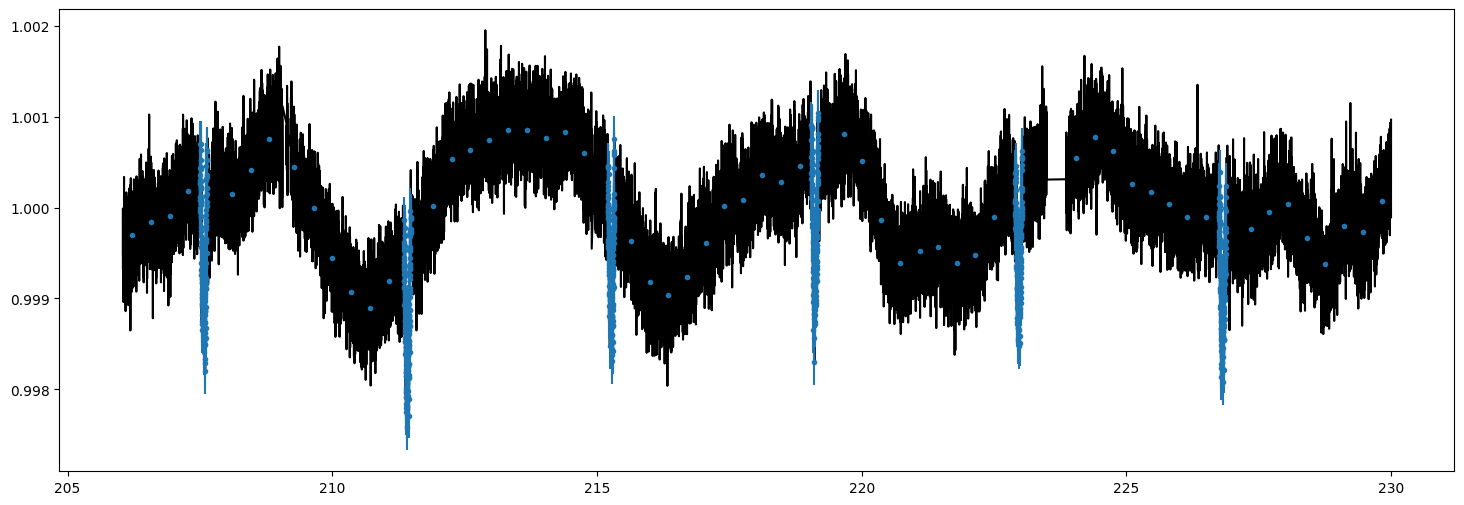

In [61]:
plt.figure(figsize=(18,6))
plt.plot(t, flux_obs, color='k')
plt.errorbar(t_, flux_, yerr=sigma_flux_, fmt='.')
# plt.xlim(418,420)

(211.0, 212.0)

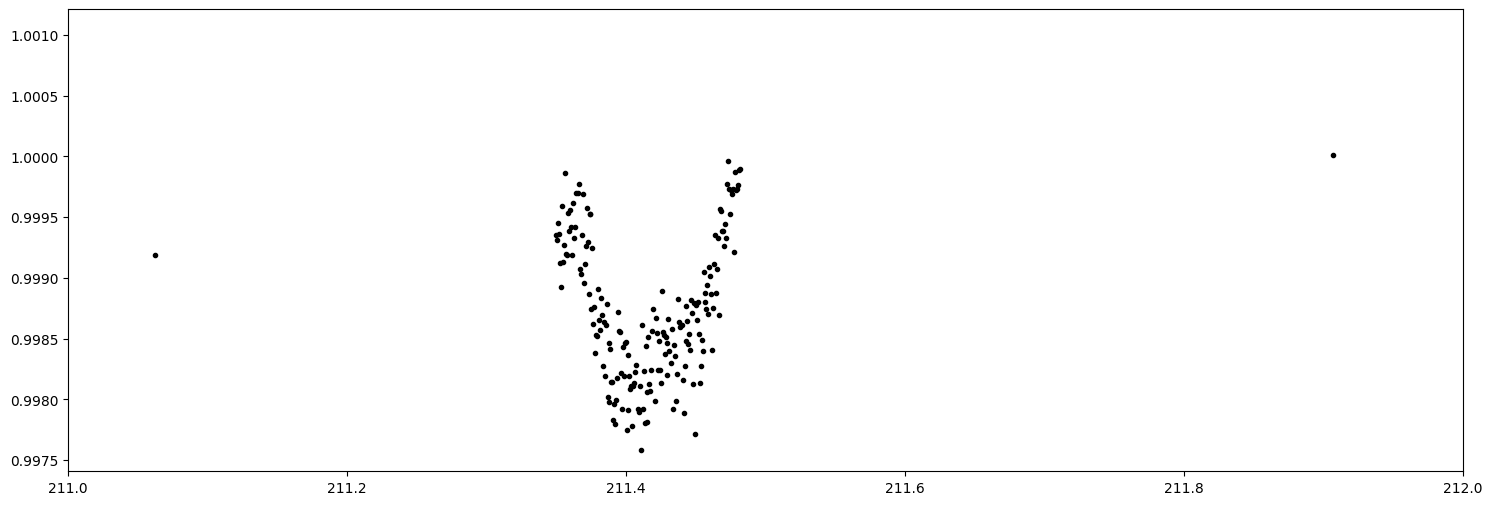

In [62]:
plt.figure(figsize=(18,6))
plt.plot(t_, flux_, 'k.')
plt.xlim(211,212)

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


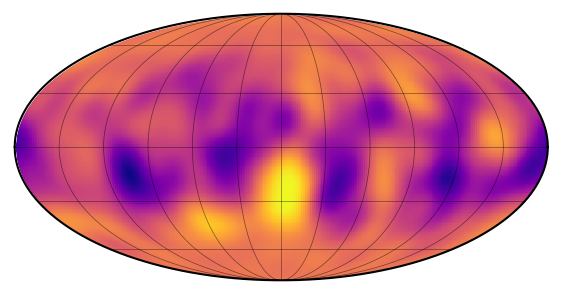

In [50]:
sp.visualize(y_true)

In [51]:
ylm_draw = ssp.sample_ylm_conditional(t_, flux_, sigma_flux_).eval()[0,:]

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


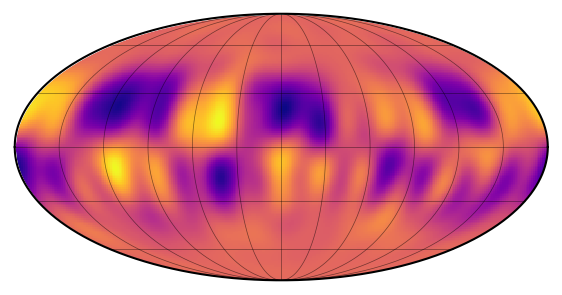

In [52]:
sp.visualize(ylm_draw)

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


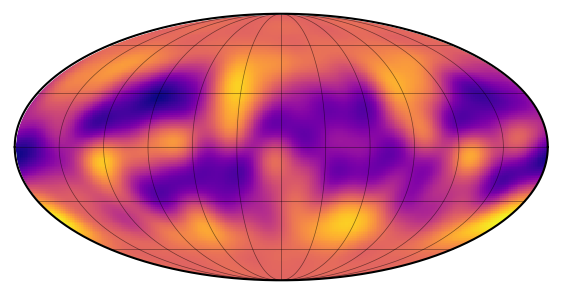

In [55]:
sp.visualize(ssp.a.eval())

# Inference

In [63]:
# Set some free params & get the model
p = dict(params)

p['star.prot']['free'] = True
p['star.obl']['free'] = True
p['star.inc']['free'] = True

p['planet.porb']['free'] = True
p['planet.t0']['free'] = True
p['planet.r']['free'] = True
p['planet.inc']['free'] = True

free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(t_, flux_, sigma_flux_, p)

In [64]:
free

['planet.inc',
 'planet.porb',
 'planet.t0',
 'planet.r',
 'star.inc',
 'star.prot',
 'star.obl']

In [65]:
# Optimize
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")

optimizing logp for variables: [b, planet.rlog, planet.t0, planet.porb, star.obl_ori_z, star.obl_ori_y, star.obl_ori_x, star.inc_ori_z, star.inc_ori_y, star.inc_ori_x, star.protlogp]



planet.inc: 90.32099952477587 [90]
planet.porb: 3.8498496719931254 [3.84937278]
planet.t0: 122.80775392449326 [122.88]
planet.r: 0.18823553196224993 [0.10740873711118132]
star.inc: 80.19661325561114 [89]
star.prot: 5.561158605036387 [5.66]
star.obl: -29.483839316041102 [-20.0]


message: Desired error not necessarily achieved due to precision loss.
logp: -16586.103739463782 -> -553.6312660225361


In [66]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        chains=1,
        cores=4,
        target_accept=0.9,
        return_inferencedata=False,
    )

Sequential sampling (1 chains in 1 job)
NUTS: [b, planet.rlog, planet.t0, planet.porb, star.obl_ori_z, star.obl_ori_y, star.obl_ori_x, star.inc_ori_z, star.inc_ori_y, star.inc_ori_x, star.protlogp]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 43179 seconds.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


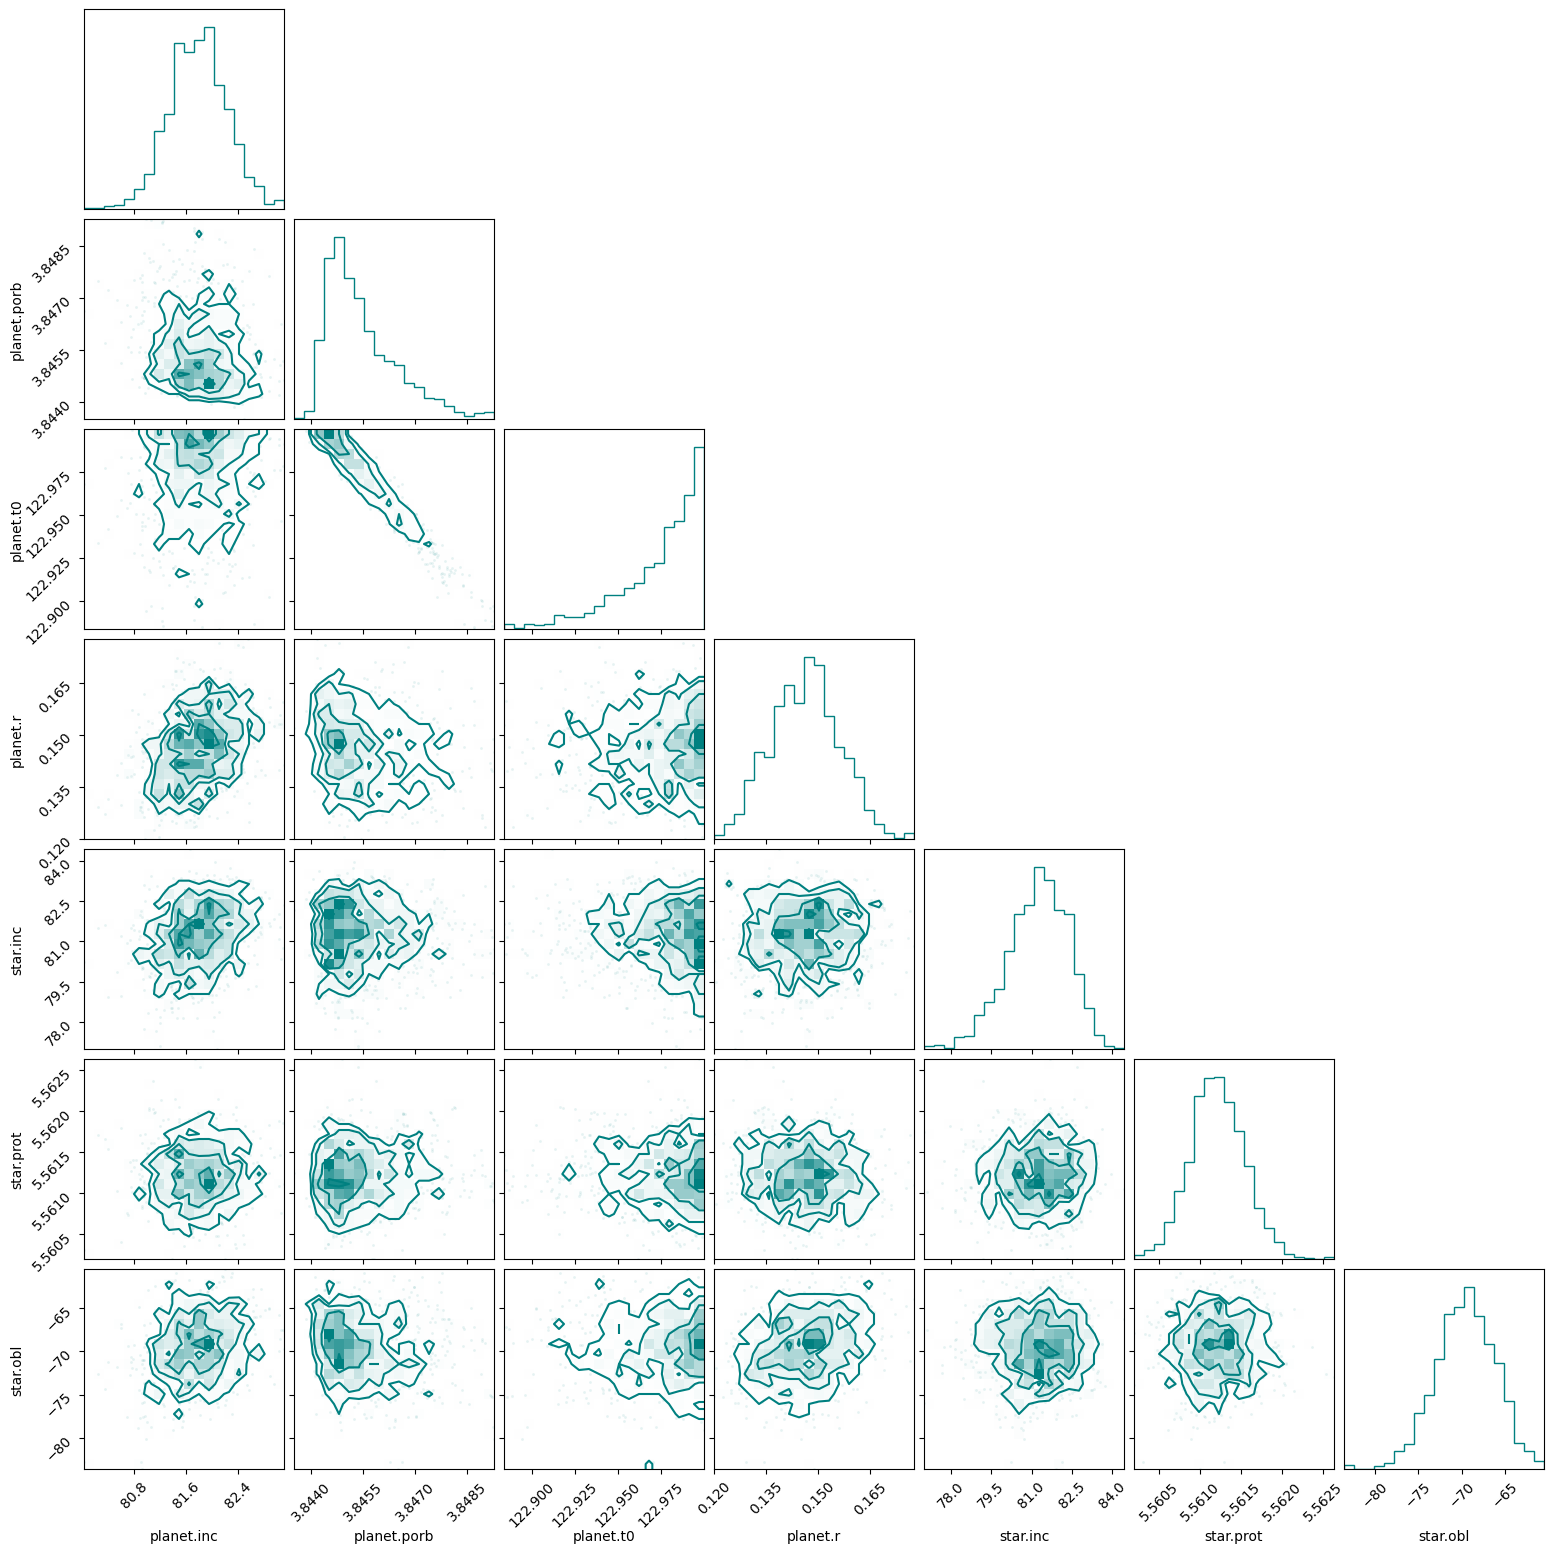

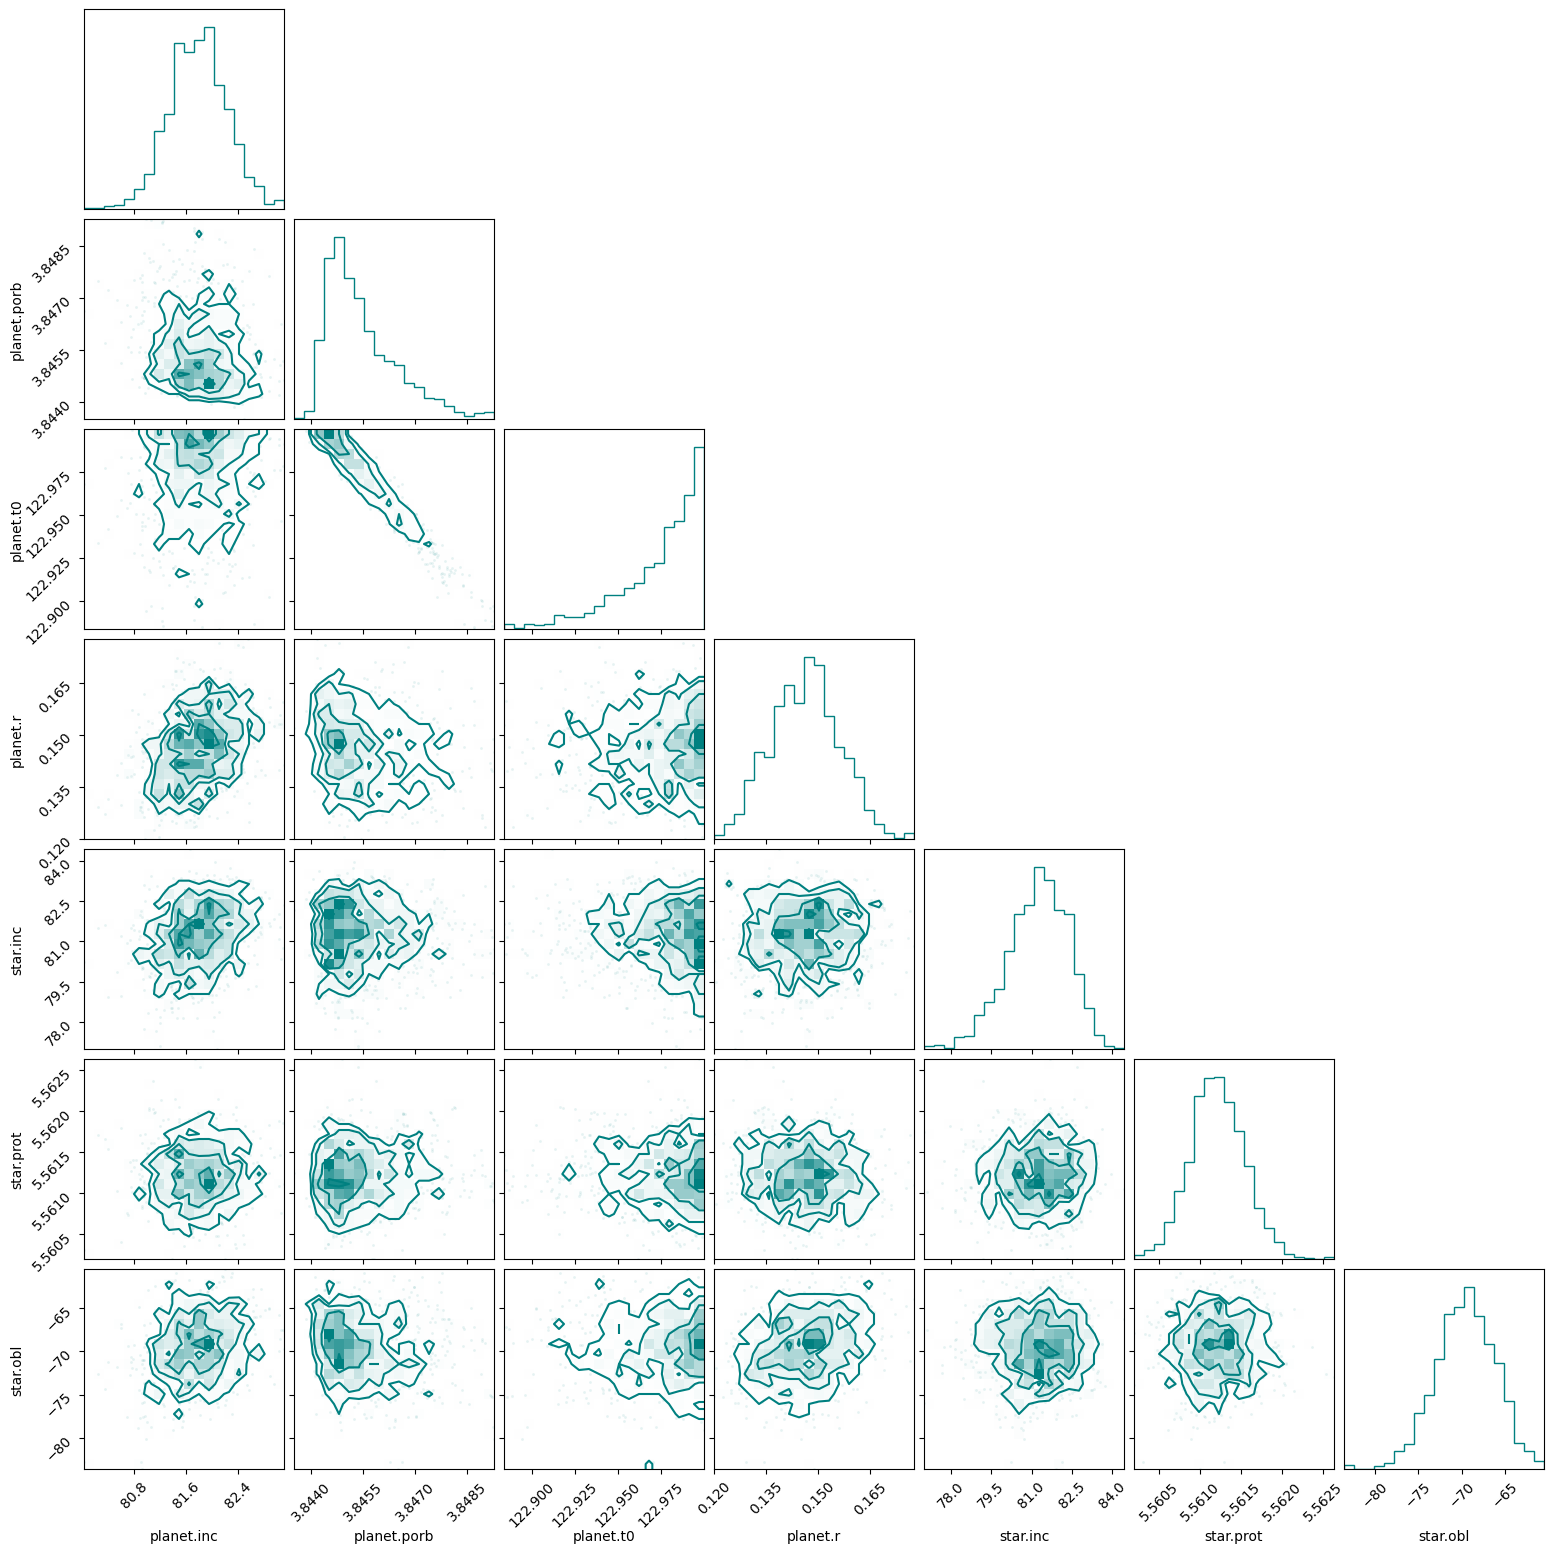

In [67]:
samples = pm.trace_to_dataframe(trace,varnames=free)
corner(np.array(samples),labels=free,truths=[params[x]['truth'] for x in free], color='teal', truth_color='orchid')

### let's save our trace

In [68]:
az.to_netcdf(trace,'SSP-koi4-star-planet-short-lc.nc')

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


'SSP-koi4-star-planet-short-lc.nc'

In [69]:
# the summary
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
star.inc_ori_x,-0.071,1.187,-2.004,2.104,0.067,0.048,308.0,244.0,NaN
star.inc_ori_y,0.012,1.175,-2.057,2.113,0.066,0.047,322.0,571.0,NaN
star.inc_ori_z,0.240,0.096,0.085,0.419,0.005,0.004,334.0,416.0,NaN
star.obl_ori_x,0.434,0.233,0.074,0.898,0.013,0.009,343.0,628.0,NaN
star.obl_ori_y,-1.159,0.579,-2.166,-0.135,0.031,0.022,352.0,530.0,NaN
star.obl_ori_z,-0.014,1.043,-2.022,1.884,0.047,0.036,499.0,408.0,NaN
star.protlogp,1.716,0.000,1.716,1.716,0.000,0.000,476.0,446.0,NaN
star.prot,5.561,0.000,5.561,5.562,0.000,0.000,476.0,446.0,NaN
star.inc,81.224,1.127,79.155,83.292,0.037,0.026,922.0,901.0,NaN
star.obl,-69.583,3.438,-76.117,-63.676,0.140,0.099,597.0,564.0,NaN


### now, let's work with the samples from the file

In [16]:
samples_fromfile = az.from_netcdf('SSP-koi4-star-planet-short-lc.nc')

In [17]:
samples = samples_fromfile.posterior.to_dataframe()

In [18]:
samples

star.inc_ori_x  star.inc_ori_y  star.inc_ori_z  star.obl_ori_x  \
chain draw                                                                   
0     0           0.702134       -1.148479        0.247739        0.206331   
      1           1.023437       -0.390358        0.139363        0.576056   
      2          -1.150773       -0.499617        0.209804        0.452595   
      3          -0.718650       -0.372501        0.186981        0.330219   
      4           1.077539       -2.890317        0.418884        0.822676   
...                    ...             ...             ...             ...   
      995         0.992586        0.438359        0.206745        0.644536   
      996         0.685146        0.410402        0.141566        0.817173   
      997         1.565042        0.266850        0.279038        0.560147   
      998         1.886526        0.161300        0.340512        0.480706   
      999         0.241116        2.087968        0.316828        0.739328   

            star.obl_ori_y  star.obl_ori_z  star.protlogp  star.prot  \
chain draw                                                             
0     0          -0.515979        2.667130       1.715848   5.561390   
      1          -1.660217       -2.433529       1.715834   5.561312   
      2          -1.526768       -1.668659       1.715855   5.561429   
      3          -1.326513       -1.658647       1.715912   5.561743   
      4          -1.961071        1.291958       1.715758   5.560889   
...                    ...             ...            ...        ...   
      995        -1.669322        0.021666       1.715865   5.561485   
      996        -1.899643       -0.811945       1.715856   5.561437   
      997        -2.204315        0.413563       1.715773   5.560974   
      998        -2.228112        1.869718       1.715736   5.560765   
      999        -1.887770       -1.331600       1.715901   5.561685   

             star.inc   star.obl  planet.porb   planet.t0  planet.rlog  \
chain draw                                                               
0     0     79.571898 -68.204447     3.844921  122.985012    -1.880446   
      1     82.749146 -70.864446     3.845039  122.977326    -1.869417   
      2     80.506033 -73.488079     3.845474  122.983177    -2.004482   
      3     76.993016 -76.021057     3.845338  122.985743    -2.070954   
      4     82.266735 -67.241780     3.844911  122.985309    -1.782096   
...               ...        ...          ...         ...          ...   
      995   79.212424 -68.888096     3.845580  122.979594    -2.027201   
      996   79.948483 -66.723989     3.844907  122.987779    -1.904835   
      997   80.031645 -75.742123     3.844851  122.988123    -1.858997   
      998   79.804873 -77.825282     3.845231  122.988053    -1.907705   
      999   81.427881 -68.612645     3.844458  122.996075    -1.925775   

            planet.r         b  planet.inc  
chain draw                                  
0     0     0.152522  0.146355   81.584243  
      1     0.154214  0.140744   81.909103  
      2     0.134730  0.135283   82.224992  
      3     0.126065  0.137799   82.079477  
      4     0.168285  0.148938   81.434636  
...              ...       ...         ...  
      995   0.131704  0.148657   81.450881  
      996   0.148847  0.146597   81.570222  
      997   0.155829  0.141323   81.875607  
      998   0.148421  0.149495   81.402347  
      999   0.145763  0.137978   82.069121  

[1000 rows x 16 columns]

In [74]:
samples['star.prot'][0][5]

5.560626850085669

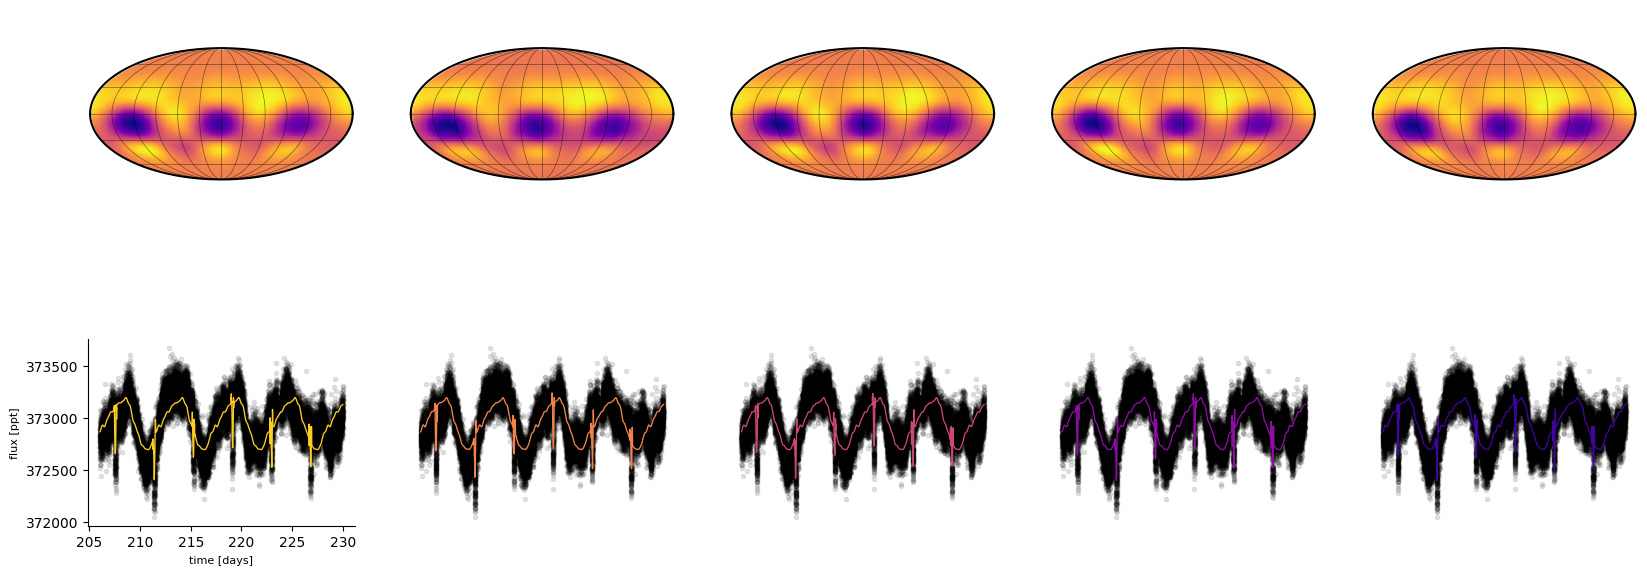

In [82]:
# plotting 5 samples
nsamples = 5
norm = Normalize(vmin=0.5, vmax=1.1)
cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (nsamples - 1))


fig, ax = plt.subplots(
    2,
    nsamples,
    figsize=(20, 8),
    gridspec_kw={
        "height_ratios": np.tile([1, 0.5], 1),
        # "width_ratios": np.append(np.ones(nsamples-1), 0.1),
    },
)

for k in range(nsamples):
    # get a random sample from the posterior distributions
    rand_index = np.random.randint(0,samples.shape[0])
    map_samples = starry.Map(15, 2)
    star = starry.Primary(map_samples, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=samples['star.prot'][0][rand_index], 
                          obl=samples['star.obl'][0][rand_index], inc=samples['star.inc'][0][rand_index]) 
    planet = starry.Secondary(
        starry.Map(0,0),
        inc=samples['planet.inc'][0][rand_index],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        porb=samples['planet.porb'][0][rand_index],
        t0=samples['planet.t0'][0][rand_index],
        r=samples['planet.r'][0][rand_index],
        m=params["planet.m"]["truth"],
        prot=1.0
    )

    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t_)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    theta = (360 * t_ / params["star.prot"]["truth"]) % 360
    
    sp_samples = StarryProcess(
        mu=params["gp.mu"]['truth'],
        sigma=params["gp.sigma"]['truth'],
        r=params["gp.r"]['truth'],
        dr=params["gp.dr"]["truth"],
        c=params["gp.c"]['truth'],
        n=params["gp.n"]['truth'],
    )

    nt = len(t)
    ssp_samples = StarryStarryProcess(sys, sp_samples, nt, len(star.map.y.eval()))

    ylm_samples = ssp_samples.sample_ylm_conditional(t, flux, sigma_flux).eval()[0,:]

    map_samples[:, :] = ylm_samples.reshape(-1)
    map_samples.show(ax=ax[0, k], projection="moll")
    ax[0, k].set_ylim(-1.5, 2.25)
    ax[0, k].set_rasterization_zorder(1)
    flux_samples = sys.design_matrix(t).eval()[:, :-1] @ ylm_samples
    ax[1, k].plot(t, flux, 'k.', alpha=0.1)
    ax[1, k].plot(t, flux_samples, color=color(k), lw=0.95, alpha=1)

    if k == 0:
        ax[1, k].spines["top"].set_visible(False)
        ax[1, k].spines["right"].set_visible(False)
        ax[1, k].set_xlabel("time [days]", fontsize=8)
        ax[1, k].set_ylabel("flux [ppt]", fontsize=8)
    else:
        ax[1, k].axis("off")


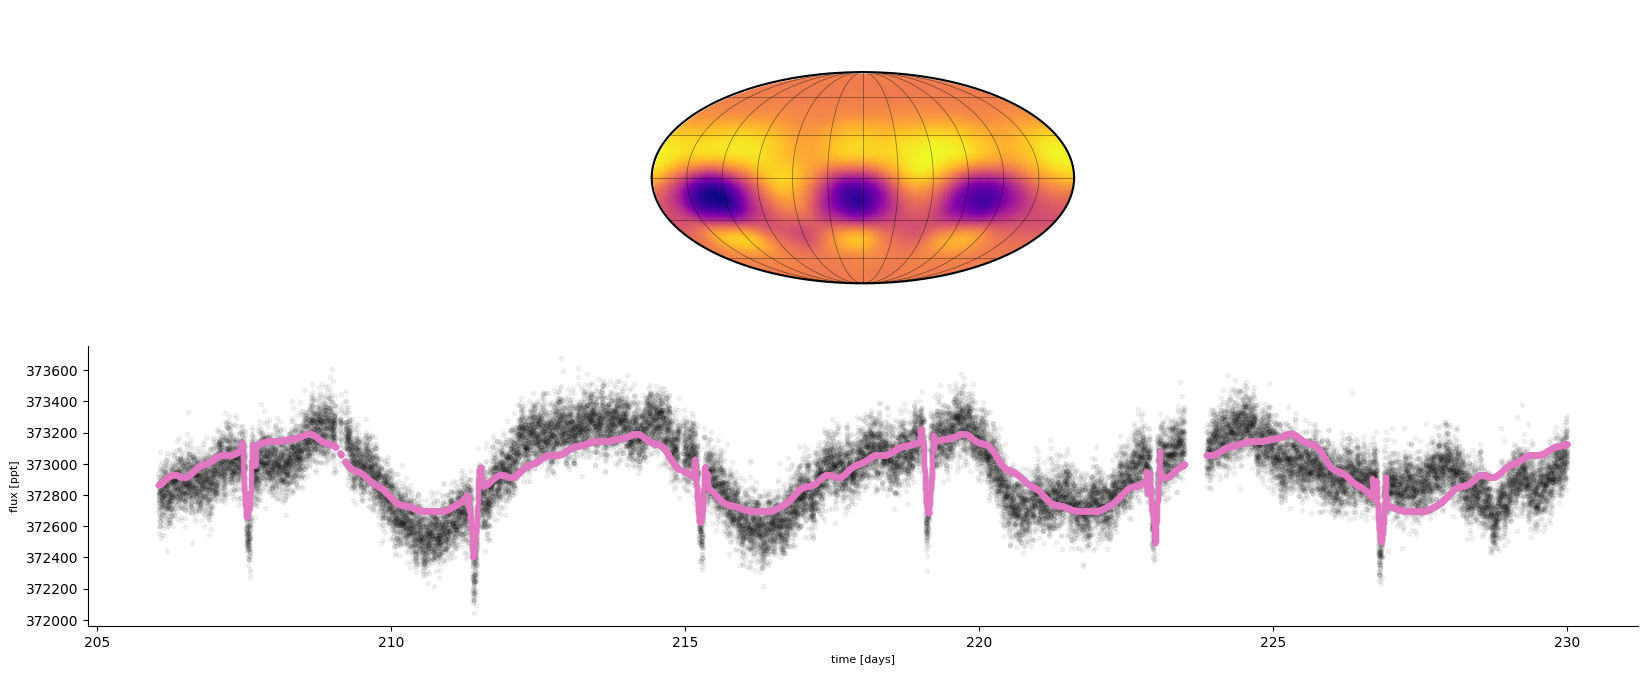

In [23]:
# plotting 5 samples
nsamples = 1
norm = Normalize(vmin=0.5, vmax=1.1)
cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (nsamples - 1))


fig, ax = plt.subplots(
    2,
    nsamples,
    figsize=(20, 8),
)

for k in range(nsamples):
    # get a random sample from the posterior distributions
    rand_index = np.random.randint(0,samples.shape[0])
    map_samples = starry.Map(15, 2)
    star = starry.Primary(map_samples, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=samples['star.prot'][0][rand_index], 
                          obl=samples['star.obl'][0][rand_index], inc=samples['star.inc'][0][rand_index]) 
    planet = starry.Secondary(
        starry.Map(0,0),
        inc=samples['planet.inc'][0][rand_index],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        porb=samples['planet.porb'][0][rand_index],
        t0=samples['planet.t0'][0][rand_index],
        r=samples['planet.r'][0][rand_index],
        m=params["planet.m"]["truth"],
        prot=1.0
    )

    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t_)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    theta = (360 * t_ / params["star.prot"]["truth"]) % 360
    
    sp_samples = StarryProcess(
        mu=params["gp.mu"]['truth'],
        sigma=params["gp.sigma"]['truth'],
        r=params["gp.r"]['truth'],
        dr=params["gp.dr"]["truth"],
        c=params["gp.c"]['truth'],
        n=params["gp.n"]['truth'],
    )

    nt = len(t)
    ssp_samples = StarryStarryProcess(sys, sp_samples, nt, len(star.map.y.eval()))

    ylm_samples = ssp_samples.sample_ylm_conditional(t, flux, sigma_flux).eval()[0,:]

    map_samples[:, :] = ylm_samples.reshape(-1)
    map_samples.show(ax=ax[0], projection="moll")
    ax[0].set_ylim(-1.5, 2.25)
    ax[0].set_rasterization_zorder(1)
    flux_samples = sys.design_matrix(t).eval()[:, :-1] @ ylm_samples
    ax[1].plot(t, flux, 'k.', alpha=0.05)
    ax[1].plot(t, flux_samples, 'C6.', lw=0.75, alpha=0.5)

    if k == 0:
        ax[1].spines["top"].set_visible(False)
        ax[1].spines["right"].set_visible(False)
        ax[1].set_xlabel("time [days]", fontsize=8)
        ax[1].set_ylabel("flux [ppt]", fontsize=8)
    else:
        ax[1].axis("off")
    
    # plt.xlim(425,430)


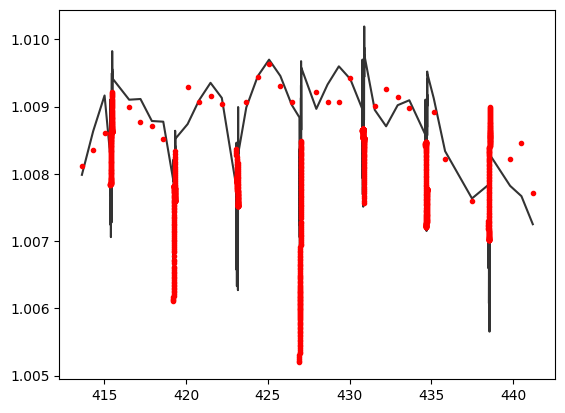

In [145]:
plt.plot(t_, flux_, 'k-', alpha=0.8)
plt.plot(t_, flux_samples, 'r.')